In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

## Defining the function and solution

In [2]:
nu = 1/(100*torch.pi)
_u_i = lambda x: -torch.sin(torch.pi*x)
_u_b = lambda t: 0*t

In [3]:
def MSE(net, u_, x, t):
    u = u_(x,t).detach().reshape(-1,1)
    u_hat = net(x,t).detach().reshape(-1,1)
    MSE = torch.mean((u - u_hat)**2)
    return MSE

In [4]:
n_x = 10 # Number of data points in interior domain
n_i = 10 # Number of initial points
n_b = 10 # Number of boundary (time) points
n_t = 10
xmin = -1
xmax = 1

# Interior of domain
x = torch.linspace(xmin, xmax, n_x, requires_grad=True)[1:-1]
t = torch.linspace(0, 1, n_t, requires_grad=True)[1:]
x, t = torch.meshgrid((x, t))
x = x.reshape(-1, 1)
t = t.reshape(-1, 1)

# Initial
x_i = torch.linspace(xmin, xmax, n_i,requires_grad=True).reshape(-1, 1)[1:-1]
t_i = torch.zeros(x_i.shape, requires_grad=True)
u_i = _u_i(x_i)

# Boundary
x_b = torch.cat((xmin*torch.ones(n_b, 1, requires_grad=True),
                 xmax*torch.ones(n_b, 1, requires_grad=True)))
t_b = torch.cat((torch.linspace(0, 1, n_b, requires_grad=True),
                torch.linspace(0, 1, n_b, requires_grad=True)), dim=0).reshape(-1, 1)
u_b = _u_b(t_b)

/opt/anaconda3/envs/ml/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


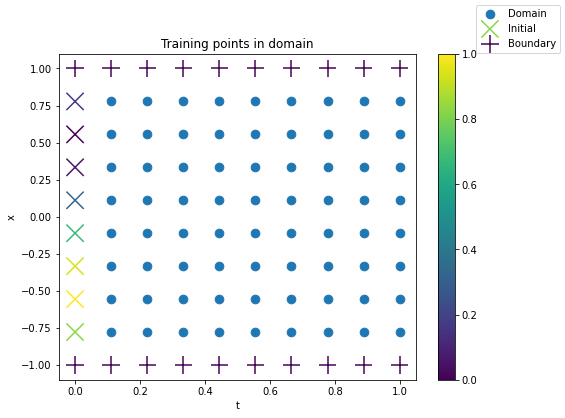

In [5]:
fig, ax = plt.subplots(figsize=(8,6))
d = ax.scatter(t.detach(), x.detach(), marker='.', s=300, label='Domain')
i = ax.scatter(t_i.detach(), x_i.detach(), c=u_i.detach(), marker='x', s=300, label='Initial')
b = ax.scatter(t_b.detach(), x_b.detach(), c=u_b.detach(), marker='+', s=300, label='Boundary')
fig.colorbar(d)
fig.legend()
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_title('Training points in domain')
plt.show()

In [6]:
class Net(nn.Module):
    def __init__(self,
        N_in, N_out, N_hid,
        N_layers=4,
        loss_func=nn.MSELoss(),
        LEARNING_RATE = 0.001,
        optimizer = optim.Adam,
        act_func=nn.Sigmoid()
                ):
        
        super(Net, self).__init__()
        self.layers = nn.Sequential(
                nn.Linear(in_features=N_in,
                    out_features=N_hid,
                    bias=True),
                act_func,
                *(nn.Linear(in_features=N_hid,
                    out_features=N_hid,
                    bias=True), act_func)*(N_layers - 1),
                nn.Linear(in_features=N_hid,
                    out_features=N_out,
                    bias=True)
            )
        
        self.loss_func = loss_func
        self.optimizer = optimizer(self.parameters(), lr=LEARNING_RATE)
        
    def forward(self, x, t):
        x = torch.cat((x, t), dim=1)
        out = self.layers(x)
        return out
    
    def loss_BC(self, x_b, t_b, u_b):
        u_b_hat = self.forward(x_b, t_b)
        loss = self.loss_func(u_b, u_b_hat.reshape(u_b.shape))
        return loss
    
    def loss_IC(self, x_i, t_i, u_i):
        u_i_hat = self.forward(x_i, t_i)
        loss = self.loss_func(u_i, u_i_hat.reshape(u_i.shape))
        return loss

    def loss_PDE(self, x, t):
        u_hat = self.forward(x, t)
        u_x_hat = torch.autograd.grad(u_hat, x, torch.ones(x.shape), create_graph=True)[0]
        u_xx_hat = torch.autograd.grad(u_x_hat, x, torch.ones(x.shape), create_graph=True)[0]
        u_t_hat = torch.autograd.grad(u_hat, t, torch.ones(t.shape), create_graph=True)[0]
        
        loss = self.loss_func(nu*u_xx_hat - u_hat*u_x_hat, u_t_hat.reshape(u_x_hat.shape))
        return loss
    
    def loss(self, x, t, x_b, t_b, u_b, x_i, t_i, u_i):
        loss = self.loss_PDE(x, t) + self.loss_BC(x_b, t_b, u_b) + self.loss_IC(x_i, t_i, u_i)
        return loss
    
    def step(self, x, t, x_b, t_b, u_b, x_i, t_i, u_i):
        self.train()
        self.optimizer.zero_grad()
        loss = self.loss(x, t, x_b, t_b, u_b, x_i, t_i, u_i)
        loss.backward(retain_graph=True)
        self.optimizer.step()
        self.eval()
        return self.loss_PDE(x, t), self.loss_BC(x_b, t_b, u_b), self.loss_IC(x_i, t_i, u_i)

In [7]:
loss = []
# loss_data = []
loss_epochs = []
epochs = 20000
xi, ti = torch.meshgrid(torch.linspace(0,1,101, requires_grad=True), torch.linspace(0,1,101, requires_grad=True))
xi, ti = xi.reshape(-1, 1), ti.reshape(-1, 1)
net = Net(N_in=2, N_out=1, N_hid=100, N_layers=1)
for e in range(epochs):
    loss.append(net.step(x, t, x_b, t_b, u_b, x_i, t_i, u_i))
    # loss_data.append(MSE(net, u_, xi, ti))
    # if e%1000 == 0:
    #     print('Epoch: {:d}. Data loss: {:.2f}'.format(e, loss_data[-1]))


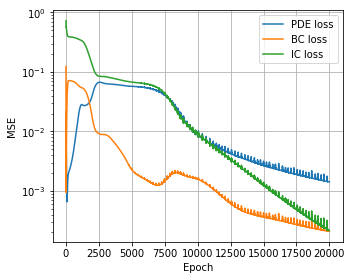

In [11]:
fig, ax = plt.subplots(figsize=(5,4))
ax.semilogy([pde.detach() for pde, bc, ic in loss], label='PDE loss')
ax.semilogy([bc.detach() for pde, bc, ic in loss], label='BC loss')
ax.semilogy([ic.detach() for pde, bc, ic in loss], label='IC loss')
# ax.semilogy(loss_data, label='Evaluation loss')
ax.legend()
ax.set_ylabel('MSE')
ax.set_xlabel('Epoch')
ax.grid()
fig.tight_layout()
fig.savefig('./figs/Burger_loss.png', dpi=600)

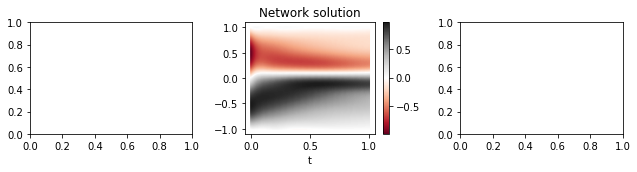

In [15]:
## Evaluate network
fig, axs = plt.subplots(1,3,figsize=(9,2.5))
xi, ti = torch.meshgrid(torch.linspace(xmin,xmax,101, requires_grad=True), torch.linspace(0,1,101, requires_grad=True))
xi, ti = xi.reshape(-1, 1), ti.reshape(-1, 1)
#x_grid = torch.hstack((xi.reshape(-1, 1), yi.reshape(-1, 1)))
# minmax = u_(xi, ti).detach()
# vmin = minmax.min()
# vmax = minmax.max()
# u = u_(xi, ti).detach()
u_hat = net(xi, ti).detach()
vmin = u_hat.min()
vmax = u_hat.max()

# m = axs[0].scatter(ti.detach(), xi.detach(), s=1, c=u, vmin=vmin, vmax=vmax)
# fig.colorbar(m, ax=axs[0])
# axs[0].set_title('True solution')
# axs[0].set_xlabel('t')
# axs[0].set_ylabel('x')
m = axs[1].scatter(ti.detach(), xi.detach(), s=1, c=u_hat, vmin=vmin, vmax=vmax, cmap='RdGy')
fig.colorbar(m, ax=axs[1])
axs[1].set_title('Network solution')
axs[1].set_xlabel('t')
# m = axs[2].scatter(ti.detach(), xi.detach(), s=1, c=u-u_hat, vmin=-max(abs(u-u_hat)), vmax=max(abs(u-u_hat)), cmap='RdGy')
# fig.colorbar(m, ax=axs[2])
# axs[2].set_title('Residual')
# axs[2].set_xlabel('t')
fig.tight_layout()
fig.savefig('./figs/burgers_2D.png', dpi=600)


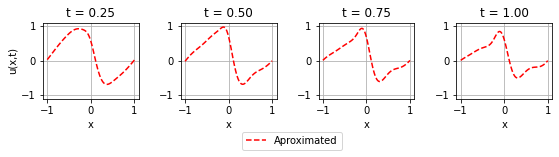

In [13]:
xi, ti = torch.meshgrid(torch.linspace(xmin,xmax,101, requires_grad=True), torch.tensor([0.25, 0.5, 0.75, 1]))
#xi, ti = xi.reshape(4, -1), ti.reshape(4, -1)
fig, axs = plt.subplots(1,4,figsize=(8,2))
for k, ax in enumerate(axs):
    x = xi[:, k].reshape(-1,1)
    t = ti[:, k].reshape(-1,1)
    # u = u_(x, t).detach()
    u_hat = net(x, t).detach()
    # ax.plot(x.detach(), u, color='blue', ls='-')
    ax.plot(x.detach(), u_hat, color='red', ls='--')
    ax.set_xlabel('x')
    ax.set_title('t = {:.2f}'.format(t[0].item()))
    ax.set_ylim([vmin-0.1, vmax+0.1])
    ax.grid()
axs[0].set_ylabel('u(x,t)')
fig.legend(['Aproximated'], loc="lower center", bbox_to_anchor=(0.53, -0.1))
fig.tight_layout()
fig.savefig('./figs/burger_eval_1D.png', dpi=600)